# Task One: Wallet Transactions

In [ ]:
!pip install -r requirements.txt

In [2]:
import requests
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

## Importing data

I use the Etherscan API to fetch the full transaction history of a well known Ethereum whale wallet belonging to a huge crypto exchange using its unique wallet address. The API token is loaded from the `.env` file. 

In [20]:
load_dotenv()
TOKEN = os.getenv("ETHERSCAN_TOKEN")
WALLET_ADDRESS = "0x742d35Cc6634C0532925a3b844Bc454e4438f44e"

# Etherscan API URL
url = f"https://api.etherscan.io/api?module=account&action=txlist&address={WALLET_ADDRESS}&startblock=0&endblock=99999999&sort=desc&apikey={TOKEN}"

# Fetch data and convert to JSON
response = requests.get(url)
data = response.json()

I extract the hourly required data from the dictionary into a dataframe which has 10000 observations. The data contains many columns such block id, unique transaction hash, nonce (how many transactions sender has made), index, wallet address sending/receiving money, amount transferred, gas used in transaction, among others.

In [23]:
df = pd.DataFrame(data["result"])
print(df.columns)
print(df.shape)

Index(['blockNumber', 'timeStamp', 'hash', 'nonce', 'blockHash',
       'transactionIndex', 'from', 'to', 'value', 'gas', 'gasPrice', 'isError',
       'txreceipt_status', 'input', 'contractAddress', 'cumulativeGasUsed',
       'gasUsed', 'confirmations', 'methodId', 'functionName'],
      dtype='object')
(10000, 20)


## Data preparation

I choose to keep only a few columns of interest:
1. `from`: sender wallet address
2. `to`: receiver wallet address
3. `value`: amount sent (in Wei, which is the smallest ETH unit)

To prepare the data for analysis, I convert the column types appropriately, converting `from` and `to` columns to str type and `value` column to float type before dividing to get value in ETH instead of Wei.

In [ ]:
df = df[["from", "to", "value"]]
df["from"] = df["from"].astype(str)
df["to"] = df["to"].astype(str)
df["value"] = df["value"].astype(float) / 1e18 # Convert from Wei to ETH by dividing by 1e18

                                         from  \
0  0x742d35cc6634c0532925a3b844bc454e4438f44e   
1  0x7145d8cfd511a7674cf8149d19186fbc83241c49   
2  0xd01a3811159284c3f601a3e4ec07f6f6092511f7   
3  0xd01a3811159284c3f601a3e4ec07f6f6092511f7   
4  0xd01a3811159284c3f601a3e4ec07f6f6092511f7   

                                           to         value  
0  0x77134cbc06cb00b66f4c7e623d5fdbf6777635ec  25000.000000  
1  0x742d35cc6634c0532925a3b844bc454e4438f44e      0.000001  
2  0x742d35cc6634c0532925a3b844bc454e4438f44e      0.000220  
3  0x742d35cc6634c0532925a3b844bc454e4438f44e      0.000260  
4  0x742d35cc6634c0532925a3b844bc454e4438f44e      0.001234  


I aim to create a bi-directional weighted with nodes as wallets and arrows as transactions to visualise the 20 most recent transactions involving this wallet. I filter the data for the 20 most recent observations with non-zero value, saving them into a dataframe called `plot`.

In [15]:
plot = df[df["value"] != 0]
plot = plot.head(20)[["from", "to", "value"]]

## Data visualisation: bi-directional wieghted graph

From the 20 transactions, I obtain a set of distinct sending and receiving wallets which will be used as nodes in the graph. There are 11 wallets in the set.

In [25]:
wallets_from = plot["from"].tolist()
wallets_to = plot["to"].tolist()
wallets = set(wallets_from + wallets_to)
print(wallets)
print(len(wallets))


{'0x9f3f6637076a51cd689331c0f57b08234400e497', '0x7145d8cfd511a7674cf8149d19186fbc83241c49', '0xbae678079edd3858972b9b91bc727e1875cb8003', '0xd01a3811159284c3f601a3e4ec07f6f6092511f7', '0x77134cbc06cb00b66f4c7e623d5fdbf6777635ec', '0x0dd21ae4c14e80cea02de939449430cd90e4db8c', '0x59abc82208ca435773608eb70f4035fc2ea861da', '0xd7c7175741cedf43461384167d4ad9b2b88e237a', '0xeba8d3a502955c29790f53238ca5ed44a3fee2b3', '0x742d35cc6634c0532925a3b844bc454e4438f44e', '0x8f0d024e780b7e2fd633a4d6d43631a96e8cb059'}
11


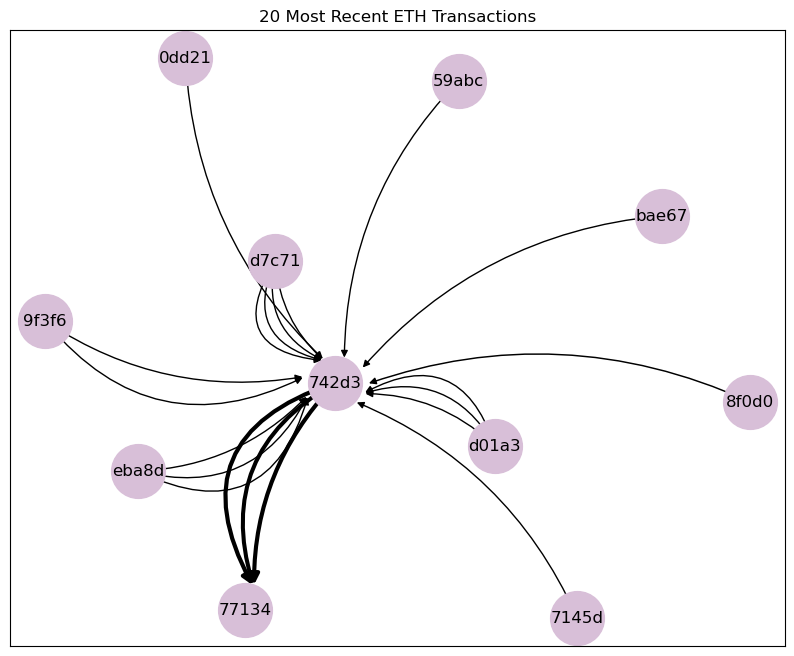

In [ ]:
# Create a directed multigraph to represent transactions
graph = nx.MultiDiGraph()

# Add graph nodes representing unique wallets
graph.add_nodes_from(wallets)

# Define labels as a short unique 5-character substring of wallet address
labels = {wallet: wallet[2:7] for wallet in graph.nodes()}

# Add graph edges for each transaction, with transaction value as weight
for index, row in plot.iterrows():
    graph.add_edge(row["from"], row["to"], weight = float(row["value"]))

# Scale edge weights using log for easier visualisation
edge_weights = [math.log1p(data["weight"]) for u, v, key, data in graph.edges(keys = True, data = True)]
edge_weights = 1 + 2 * (np.array(edge_weights) - min(edge_weights)) / (max(edge_weights) - min(edge_weights))

# Initialise figure
pos = nx.spring_layout(graph, k = 2.0, iterations = 200, weight = None)
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Draw graph nodes and labels
nx.draw_networkx_nodes(graph, pos, node_size = 1500, node_color = "thistle", ax = ax)
nx.draw_networkx_labels(graph, pos, labels = labels, ax = ax)

node_radius = 0.08 

# Draw edges as curved arrows to avoid overlaps, with width proportional to transaction value
for i, (u, v, key, data) in enumerate(graph.edges(keys = True, data = True)):
    x1, y1 = pos[u]
    x2, y2 = pos[v]

    # Compute vector from source to target
    dx = x2 - x1
    dy = y2 - y1
    length = np.sqrt(dx**2 + dy**2)

    # Scale to stop arrow short of target node (to prevent node and arrowhead from overlapping)
    scale = max(0, (length - node_radius) / length)
    x2_offset = x1 + dx * scale
    y2_offset = y1 + dy * scale

    # Code diference curvature for each edge in the case of multi-edges
    rad = 0.2 * (key + 1) 
    width = edge_weights[i]

    arrow = FancyArrowPatch(
        (x1, y1),
        (x2_offset, y2_offset),
        connectionstyle = f"arc3, rad = {rad}",
        arrowstyle = "-|>",
        color = "black",
        linewidth = width,
        mutation_scale = max(10, width * 5)
    )
    plt.gca().add_patch(arrow)

# Title and show
plt.title("20 Most Recent ETH Transactions")
plt.show()